# CITS5017 Project 1
Kaylee Molin (22734429)

September 2023

---

### Importing Relevant Packages

In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical # FIX ask if this is allowed
from sklearn.model_selection import GridSearchCV
# from scikeras.wrappers import KerasClassifier # for hyperparam tuning only
from tensorflow.keras.optimizers import SGD
import os, time
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay



### Loading dataset

In [3]:
# Loading the CIFAR-10 dataset and ensuring its dimensions match expectations

(X_train_original, y_train_original), (X_test_original, y_test_original) = tf.keras.datasets.cifar10.load_data()

# Asserting that the loaded dataset has the correct dimensions
assert X_train_original.shape == (50000, 32, 32, 3)  # Training images should be 50,000 samples of 32x32 pixels in RGB.
assert X_test_original.shape == (10000, 32, 32, 3)   # Test images should be 10,000 samples of 32x32 pixels in RGB.
assert y_train_original.shape == (50000, 1)          # Training labels should have a shape of (50000, 1).
assert y_test_original.shape == (10000, 1)           # Test labels should have a shape of (10000, 1).

170498071/170498071 [==============================] - 3s 0us/step


### Normalising the pixel values to be between 0 and 1
These models perform better when data is in this range.

In [4]:
# Normalising the pixel values of training and test data by scaling them to the range [0, 1].
X_train_norm, X_test = X_train_original/255.0, X_test_original/255.0
y_test=y_test_original
y_train = y_train_original

### (i) Forming a validation set from the training set

To create a validation set, we are using an 85/15 ratio, dividing the current training data into a reduced training set and a separate validation set. The original testing set remains unchanged.

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train_norm, y_train, test_size=0.15, random_state=22, stratify=y_train_original)

# Print the shapes of the resulting datasets
print("Training set shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("\nValidation set shapes:")
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)
print("\nTest set shapes:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Training set shapes:
X_train: (42500, 32, 32, 3)
y_train: (42500, 1)

Validation set shapes:
X_val: (7500, 32, 32, 3)
y_val: (7500, 1)

Test set shapes:
X_test: (10000, 32, 32, 3)
y_test: (10000, 1)


> The dimensions of each set is displayed above. The 'y' data contains the corresponding labels for each instance in the dataset.

### (ii) Function to display 20 randomly sampled images

In [6]:
def display_random_subset(X, y, class_names, title):
    '''
    Display a random subset of images with their corresponding class labels.

    Parameters:
        X (numpy.ndarray):  The input images.
        y (numpy.ndarray):  The corresponding class labels.
        class_names (list): A list of class names.
        title (str):        The title for the figure.

    '''
    plt.figure(figsize=(12, 6))
    indices = np.random.randint(0, len(X), size=20)

    for i, index in enumerate(indices):
        plt.subplot(4, 5, i+1)
        plt.imshow(X[index])
        plt.title(class_names[y[index][0]])
        plt.axis('off')

    plt.suptitle(title, fontsize=16)  # Adding a title to the entire figure
    plt.subplots_adjust(wspace=0.2, hspace=0.4)  # Adjusting the horizontal and vertical space
    #plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjusting layout for the title
    plt.show()


In [7]:
# Load class names from TFDS
# maybe just define them? FIX
dataset_info = tfds.builder("cifar10")
class_names = dataset_info.info.features["label"].names

### Displaying 20 random images from the training set

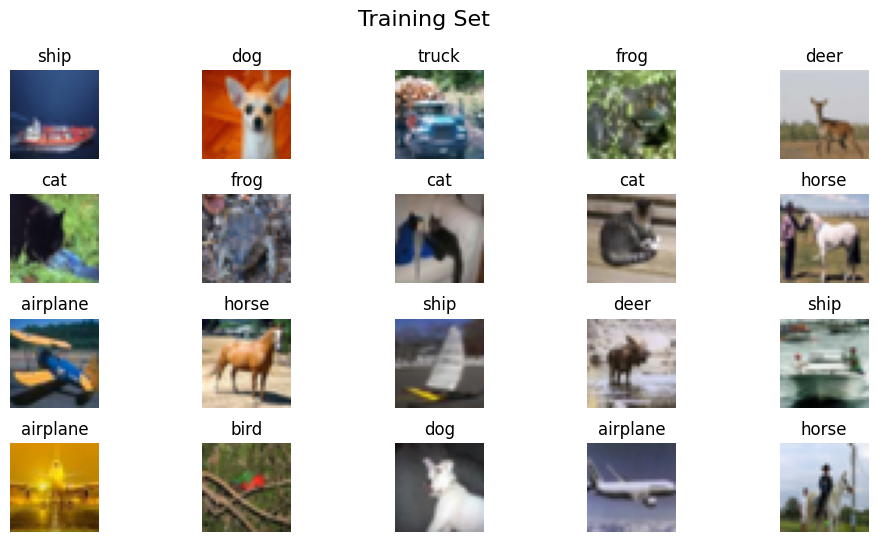

In [8]:
display_random_subset(X_train, y_train, class_names, "Training Set")

### Displaying 20 random images from the validation set

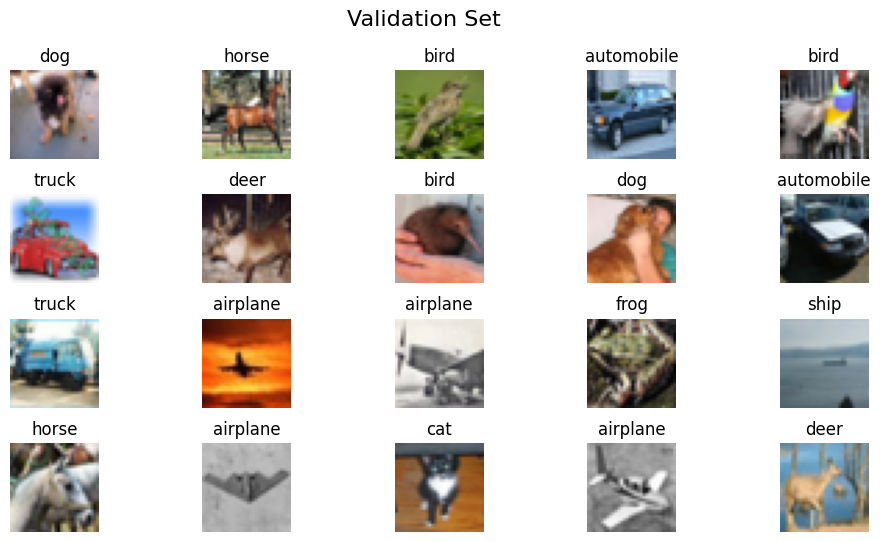

In [9]:
display_random_subset(X_val, y_val, class_names, "Validation Set")

### Displaying 20 random images from the testing set

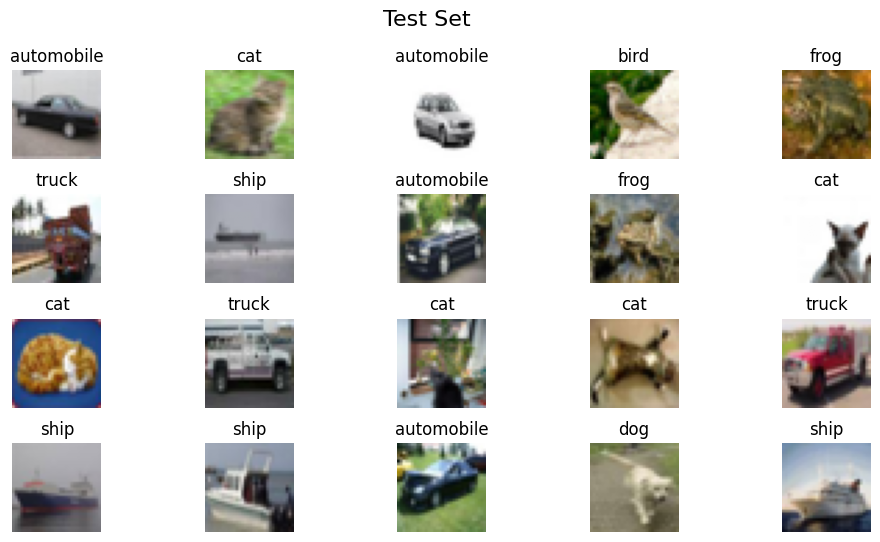

In [10]:
display_random_subset(X_test, y_test, class_names, "Test Set")

In [11]:
# ds, ds_info = tfds.load('cifar10', split='train', with_info=True)
# fig = tfds.show_examples(ds, ds_info)

In [12]:
# Get the number of classes
num_classes = len(class_names)

# y_train = to_categorical(y_train, num_classes)
# y_val = to_categorical(y_val, num_classes)
# y_test = to_categorical(y_test, num_classes)

In [13]:
# X_train.shape,X_test.shape,y_train.shape,y_test.shape


### (iii) Implementing an MLP

In [14]:
def create_mlp_model(learning_rate=0.01, weight_initializer='glorot_uniform', dropout_rate=0):
    '''
    Create an MLP model with customisable hyperparameters.

    Parameters:
        learning_rate (float):      The learning rate for the optimizer.
        weight_initializer (str):   The weight initialisation method for layers.
        dropout_rate (float):       The dropout rate for dropout layers.

    Returns:
        keras.models.Sequential: An MLP model.
    '''
    model = Sequential([
        Flatten(input_shape=[32, 32, 3]),
        Dense(512, activation='relu', kernel_initializer=weight_initializer),
        Dropout(dropout_rate),
        Dense(256, activation='relu', kernel_initializer=weight_initializer),
        Dropout(dropout_rate),
        Dense(10, activation='softmax')
    ])

    optimizer = SGD(learning_rate=learning_rate)
    # optimizer=tf.keras.optimizers.legacy.Adam()

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

> The above code defines the architecture of the MLP model. This MLP consists of an input layer, two hidden layers, and an output layer.

**Architecture**

>*Input layer*:
- The inputted images have dimensions (32, 32, 3). When flattened, the resulting array is 3072 long.

>*Hidden layers*:
- This model uses two hidden layers, one with 512 neurons and the other with 256 neurons and has been chosen purposefully. Firstly, it reduces model complexity, which can prevent overfitting to the training data. Secondly, it accelerates training as fewer parameters need tuning. This configuration of neurons in the hidden layers aligns with common choices in various neural network architectures.
- The input layer begins with 3072 neurons, and a gradual reduction in the number of neurons in each layer results in an efficient and effective model.
- I did also try using more neurons and 3 hidden layers, however, the increase in accuracy was minimal. Hence, I opted for a simpler model with comparable accuracy.
- I opted for the $ReLU$ (Rectified Linear Unit) activation function, which transforms inputs into values greater than or equal to zero. $ReLU$ is quick and effective in addressing the vanishing gradient problem that can arise with other activation functions.

>*Output layer*:
- The output layer consists of 10 neurons, corresponding to the 10 possible classes in the dataset.
- The activation function used in this layer is softmax. Softmax is chosen here because it is well-suited for multi-class classification problems, providing probability-like outputs that represent the likelihood of an input belonging to each class.

>*Optimisation*:
- Stochastic Gradient Descent (SGD) was chosen for this model. SGD iteratively updates the model's parameters based on the gradient of the loss function with respect to those parameters.
- Its adaptability and broad applications make it a suitable choice for optimising the MLP's weights and biases in this model.

### Exploring Hyperparameter Settings
> The following code aims to find the best hyperparameter combination for maximising the accuracy using the above model. It has been commented out as training has already been completed. It iterates through different hyperparameter combinations, training a model for each, and outputting the accuracy and loss.

In this experimentation, I focused on three hyperparameters: `weight_initializations`, `dropout_rates` and `learning_rates`.

1. Weight Initialisations
    - I chose to experiment with two common techniques: `glorot_uniform` and `he_normal`
    - `glorot_uniform` (also known as Xavier initialization) aims to keep the variance of activations roughly consistent across layers. `he_normal` (He initialization) is particularly suitable for deep networks and can handle the vanishing gradient problem well.
    - He initialisation aligns well with ReLU and its variants, while Glorot initialisation suits other functions, including Softmax, making it relevant here.

2. Dropout Rates
    - Dropout is a regularisation technique that aids in preventing overfitting. I tested two dropout rates: 0 and 0.2.
    - A rate of 0 represents no dropout, while 0.2 means that 20% of neurons were dropped out during training. 0.2 is used as the default dropout value.

3. Learning Rates
    - Learning rate controls the step size during training. I experimented with two values: 0.01 and 0.
    - A lower learning rate (0.01) tends to result in slower but more stable convergence, while a higher rate (0.1) can lead to faster but potentially less stable learning. The goal was to find a balance that achieves optimal training performance.



In [15]:
# weight_initializations = ['glorot_uniform', 'he_normal']
# dropout_rates = [0, 0.2]
# learning_rates = [0.01, 0.1]

# # Lists to store results
# results = []

# for weight_init in weight_initializations:
#     for dropout_rate in dropout_rates:
#         for learning_rate in learning_rates:
#             model = create_mlp_model(learning_rate=learning_rate, weight_initializer=weight_init, dropout_rate=dropout_rate)

#             # Define early stopping callback
#             early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#             # Train the model with early stopping on the validation set
#             history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

#             # Evaluate the model on the test set
#             test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

#             # Print results for each combination of hyperparameters
#             print(f"Weight Init: {weight_init}, Dropout Rate: {dropout_rate}, Learning Rate: {learning_rate}")
#             print("Test loss:", test_loss)
#             print("Test accuracy:", test_accuracy)
#             print("-" * 40)

#             # Store results
#             results.append({
#                 'Weight Init': weight_init,
#                 'Learning Rate': learning_rate,
#                 'Dropout Rate': dropout_rate,
#                 'Test Accuracy': test_accuracy
#             })

# # Print results
# for result in results:
#     print("Weight Init:", result['Weight Init'])
#     print("Learning Rate:", result['Learning Rate'])
#     print("Dropout Rate:", result['Dropout Rate'])
#     print("Test Accuracy:", result['Test Accuracy'])


**Optimal Hyperparameter Combination**

>The combination of hyperparameters that resulted in the highest accuracy are:

- **Weight Initialization**: `glorot_uniform`
- **Dropout Rate**: `0.2`
- **Learning Rate**: `0.01`
- **Epochs**: `46`
- **Optimizer**: `SGD`


**Validation Results**

- **Validation Accuracy**: 0.527
- **Validation Loss**: 1.324

**Explanation:**

- **Weight Initilisation (`glorot_uniform`)**: This initialisation method sets the initial weights of the model in a way that helps mitigate issues like vanishing or exploding gradients during training. It's suitable for ReLU activation functions, which were used in this model.

- **Dropout Rate (0.2)**: A dropout rate of 0.2 means that during training, 20% of the neurons in the hidden layers were randomly dropped out or deactivated. This regularization technique helps prevent overfitting, enhancing the model's generalization capabilities.

- **Learning Rate (0.01)**: The learning rate determines the step size during the gradient descent optimization process. A learning rate of 0.01 was chosen, which is a common starting point. It allows for effective convergence without making overly large steps that might cause the optimization process to diverge.

- **Epochs (46)**: The model was trained for 46 epochs, meaning it went through the entire training dataset 46 times. This number of epochs was found to be optimal for achieving the highest accuracy on the validation dataset.

- **Optimizer (SGD)**: Stochastic Gradient Descent (SGD) was chosen as the optimization algorithm. It's a fundamental and versatile optimizer used for training neural networks. Combined with the selected learning rate, it helped fine-tune the model's parameters effectively.


>This combination achieved a validation accuracy of approximately 52.7% and a validation loss of 1.324. It is the most effective in terms of maximising accuracy on the validation dataset. However, this accuracy is still very low, with accuracte predictions just over half of the time.

>MLPs are not the most suitable architecture for image classification tasks. MLPs struggle to capture the intricate spatial relationships and patterns within images.

### Checking if Saved Model Exists

In [16]:
from google.colab import drive
drive.mount('/content/drive/')
%cd '/content/drive/MyDrive/Colab Notebooks/DL-Assignment1'

Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks/DL-Assignment1


In [17]:
def load_or_train_model(model_filename, early_stopping, model_type):

  try:
    # Try to load the model
    model = tf.keras.models.load_model(model_filename)
    print("Model already exists. Training it for 1 more epoch.")
    model.summary()
    history = model.fit(X_train, y_train, epochs = 1, validation_data = (X_val, y_val), callbacks = [early_stopping])

  except OSError:
    if model_type == 'MLP':
      # Model file does not exist, create and train a new model
      print("Cannot find an existing MLP model in the current directory. Creating and training a new model.")
      model = create_mlp_model(learning_rate=0.01, weight_initializer='glorot_uniform', dropout_rate=0.2)
      model.summary()

    else:
      print("Cannot find an existing CNN model in the current directory. Creating and training a new model.")
      model = create_cnn_model(kernel_size=(5, 5), num_kernel=64, activation_function='relu') #FIX
      model.summary()

    history_mlp = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Save the trained model
    model.save(model_filename) #.h5 check FIX
    print("Model has been saved.")
    print(model.type())

  return model


In [18]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_mlp = load_or_train_model('Molin_Kaylee-MLP', early_stopping, 'MLP')

Model already exists. Training it for 1 more epoch.
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 3072)              0         
                                                                 
 dense_24 (Dense)            (None, 512)               1573376   
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                                 
 dense_25 (Dense)            (None, 256)               131328    
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                                 
 dense_26 (Dense)            (None, 10)                2570      
                                                                 
To

In [19]:
# model_filename = 'Molin_Kaylee-MLP'
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# try:
#     # Try to load the model
#     model_mlp = tf.keras.models.load_model(model_filename)
#     print("Model already exists. Training it for 1 more epoch.")
#     model_mlp.summary()
#     history_mlp = model_mlp.fit(X_train, y_train, epochs = 1, validation_data = (X_val, y_val), callbacks = [early_stopping])

# except OSError:
#     # Model file does not exist, create and train a new model
#     print("Cannot find an existing MLP model in the current directory. Creating and training a new model.")
#     model_mlp = create_mlp_model(learning_rate=0.01, weight_initializer='glorot_uniform', dropout_rate=0.2)
#     model_mlp.summary()

#     mlp_start = time.time()
#     history_mlp = model_mlp.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])
#     mlp_end = time.time()

#     # Save the trained model
#     model_mlp.save(model_filename) #.h5 check FIX
#     print("Model has been saved.")

In [20]:
model_mlp.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 1.3119 - accuracy: 0.5315


[1.3118594884872437, 0.531499981880188]

In [21]:
# THIS IS COPY AND PASTED FIX
# i changed it a bit, may need ot change more

mlp_pred_test = np.argmax(model_mlp.predict(X_test), axis=-1)
mlp_eval = model_mlp.evaluate(X_test,y_test,verbose=0)
print(f"MLP Model Accuracy: {mlp_eval[1]:.4f}, Loss: {mlp_eval[0]:.4f}\n")
print(f"MLP Average F1 Score: {f1_score(y_test, mlp_pred_test, average='macro'):.4f}\n")
# print(f"MLP F1 Scores for Different Classes:\n{classification_report(y_test, mlp_pred_test, target_names=class_names)}")

313/313 [==============================] - 1s 2ms/step
MLP Model Accuracy: 0.5315, Loss: 1.3119

MLP Average F1 Score: 0.5238



In [22]:
def plot_confusion_matrix(y_test, y_pred, display_labels=class_names, cmap=plt.cm.Purples, title="Confusion Matrix"):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    cm = confusion_matrix(y_test, y_pred, normalize='true')

    conf_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    conf_display.plot(cmap=cmap, ax=ax, xticks_rotation=90)

    # Set the title
    ax.set_title(title)

1329/1329 [==============================] - 2s 2ms/step


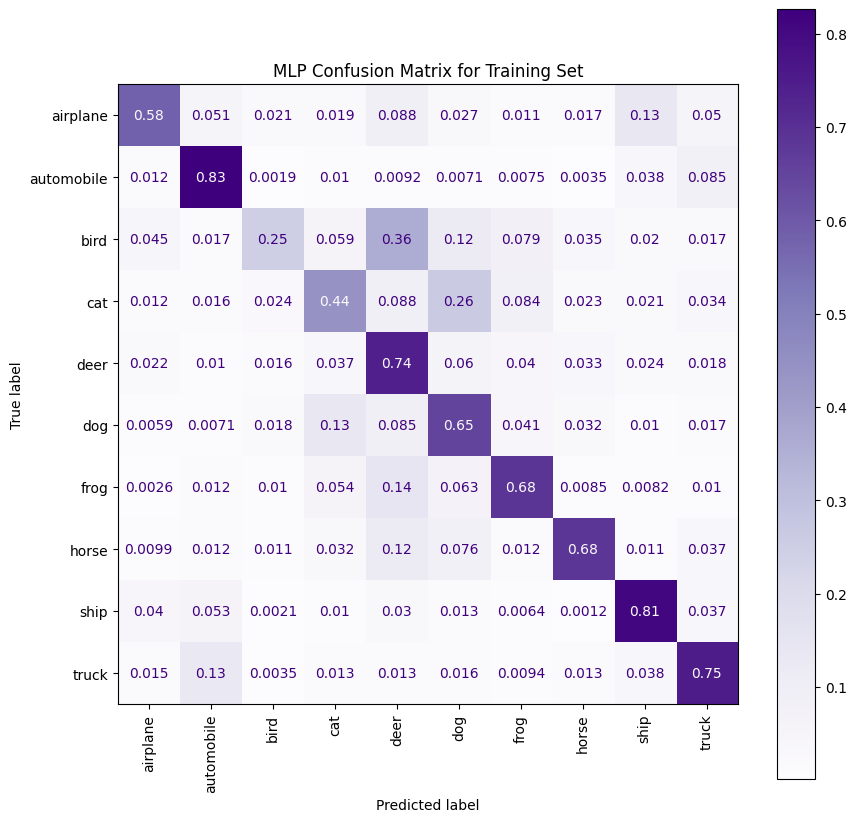

In [23]:

mlp_pred_train = np.argmax(model_mlp.predict(X_train),axis=-1)
plot_confusion_matrix(y_train, mlp_pred_train, title="MLP Confusion Matrix for Training Set")
plt.show()


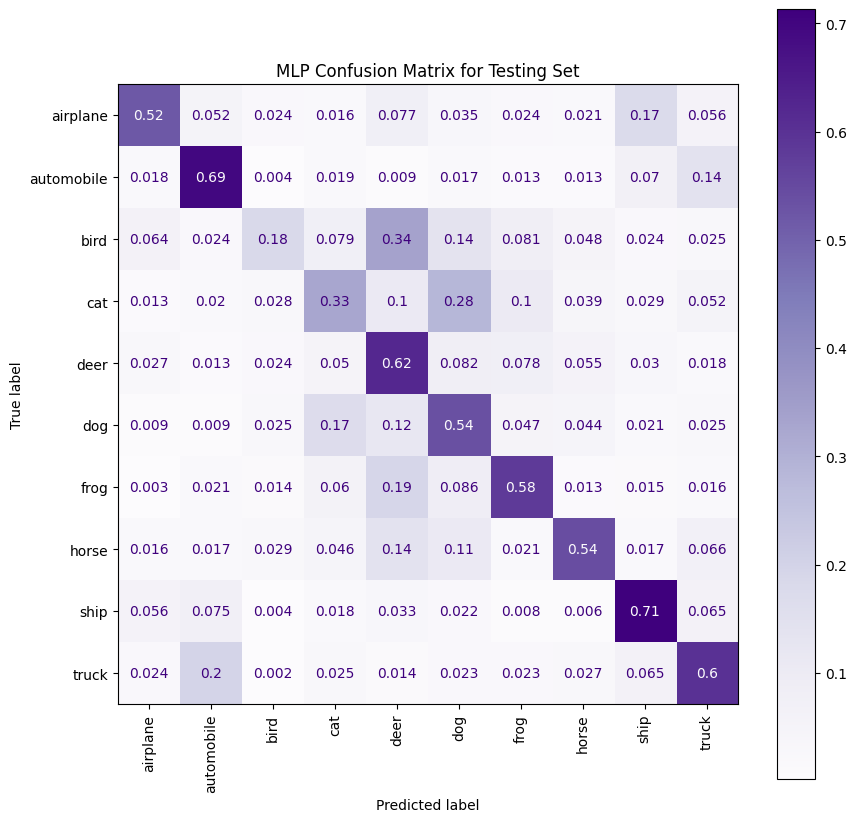

In [24]:
plot_confusion_matrix(y_test, mlp_pred_test, title="MLP Confusion Matrix for Testing Set")
plt.show()


In [25]:
# copy pasted FIX
def predict_sample_images(images, true_labels, pred_labels, rows, cols, class_names, title):
    num = rows * cols  # Define the number of images to display
    plt.figure(figsize=(15, 15))
    plt.suptitle(title, fontsize=16)
    for i in range(num):
        true_label_idx = int(true_labels[i])  # Convert to integer
        pred_label_idx = int(pred_labels[i])  # Convert to integer
        if pred_label_idx == true_label_idx:  # If prediction is correct
            ax = plt.subplot(2 * rows, cols, i + 1)
            plt.imshow(images[i])
            plt.axis('off')
            ax.set_title(f"Predicted: {class_names[pred_label_idx]}\n True: {class_names[true_label_idx]}", color='green')
        else:
            ax = plt.subplot(2 * rows, cols, i + 1)
            plt.imshow(images[i])
            plt.axis('off')
            ax.set_title(f"Predicted: {class_names[pred_label_idx]}\n True: {class_names[true_label_idx]}", color='red')
    plt.show()
    return




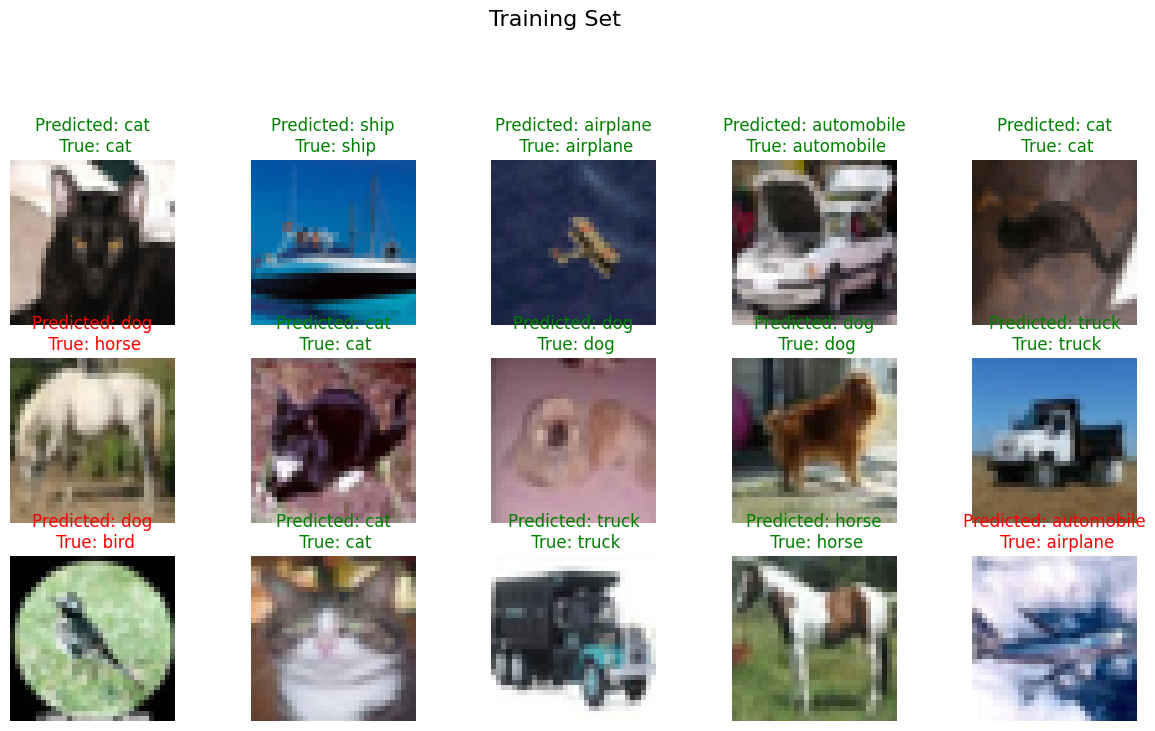

In [26]:
# MLP predict sample images
predict_sample_images(X_train, y_train, mlp_pred_train, 3, 5, class_names, 'Training Set')

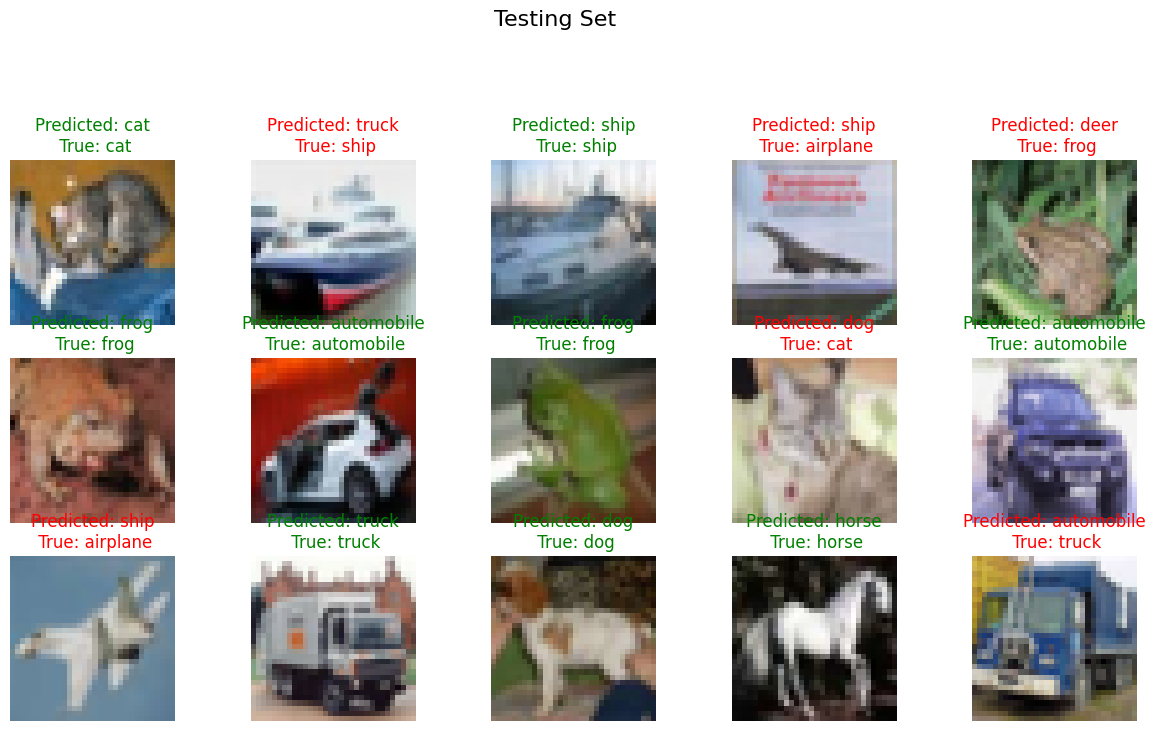

In [27]:
# MLP predict sample images
predict_sample_images(X_test, y_test, mlp_pred_test, 3, 5, class_names, 'Testing Set')

In [28]:
# # Get the number of classes
# # num_classes = len(class_names)

# # Create the MLP model
# model_mlp = tf.keras.Sequential([
#     tf.keras.layers.Flatten(input_shape=[32, 32, 3]),
#     #tf.keras.layers.Dense(1024, activation='relu'),
#     tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal'),
#     Dropout(0.2),  # Use the dropout_rate parameter here
#     # tf.keras.layers.Dense(1000, activation='relu'),
#     tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal'),
#     Dropout(0.2),  # Use the dropout_rate parameter here
#     tf.keras.layers.Dense(num_classes, activation='softmax')  # Output layer with num_classes units and softmax activation
# ])

# optimizer=tf.keras.optimizers.legacy.Adam()
# #optimizer = SGD(learning_rate=0.1)

# # Compile the model
# model_mlp.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Defining the early stopping callback
# early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# history = model_mlp.fit(X_train, y_train, epochs=100,batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

# model_mlp.summary()


### https://github.com/adameksopot/MLP-for-Cifar10-/blob/master/MLP.ipynb
### try this! very good accuracy

In [29]:
# # Hyperparameters to experiment with
# weight_initializations = ['glorot_uniform', 'he_normal'] # read https://keras.io/api/layers/initializers/ for more initialisers
# dropout_rates = [0.2, 0.4]
# input_shape=(32, 32, 3)

# for weight_init in weight_initializations:
#     for dropout_rate in dropout_rates:

#         print("Weight initialisation: {}".format(weight_init))
#         print("Dropout rate: {}".format(dropout_rate))
#         # Create the MLP model with hyperparameters
#         model = Sequential([
#             Flatten(input_shape=input_shape),
#             Dense(512, activation='relu', kernel_initializer=weight_init),
#             Dropout(dropout_rate),
#             Dense(256, activation='relu', kernel_initializer=weight_init),
#             Dropout(dropout_rate),
#             Dense(num_classes, activation='softmax')
#         ])

#         # Compile the model
#         model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#                         loss='sparse_categorical_crossentropy',
#                         metrics=['accuracy'])

#         # Define early stopping callback
#         early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#         # Train the model with early stopping on the validation set
#         history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

#         # Evaluate the model on the test set
#         test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

#         # Print results for each combination of hyperparameters
#         print(f"Weight Init: {weight_init}, Dropout Rate: {dropout_rate}")
#         print("Test accuracy:", test_accuracy)
#         print("-" * 40)

### (iv) Implementing a CNN

In [30]:
def create_cnn_model(kernel_size, num_kernel, activation_function, learning_rate=0.01, weight_initializer='glorot_uniform', dropout_rate=0.2):
    '''    '''
    model = Sequential([
        # Input layer and 1st convolutional layer
        Conv2D(num_kernel, kernel_size, activation=activation_function, input_shape=[32,32,3], kernel_initializer=weight_initializer),
        MaxPool2D(),
        BatchNormalization(),

        # 2nd convolutional layer
        Conv2D(num_kernel*2, kernel_size, activation=activation_function, kernel_initializer=weight_initializer),
        MaxPool2D(),
        BatchNormalization(),

        # Dense Layers and Output
        Flatten(),
        Dense(512, activation=activation_function),
        Dropout(dropout_rate),
        Dense(256, activation=activation_function),
        Dropout(dropout_rate),
        Dense(10, activation='softmax')

    ])

    optimizer = SGD(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [31]:
# # Hyperparameter values to explore
# kernel_sizes = [(3, 3), (5, 5)]
# num_kernels = [32, 64]
# activation_functions = ['relu', 'tanh']

# # Lists to store results
# results = []

# # Iterate through all combinations
# for kernel_size in kernel_sizes:
#     for num_kernel in num_kernels:
#         for activation_function in activation_functions:

#           early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#           model = create_cnn_model(kernel_size, num_kernel, activation_function)

#           # Train the model with early stopping on the validation set
#           history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

#           # Evaluate the model on the test set
#           test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

#           # Print results for each combination of hyperparameters
#           print(f"Kernel size: {kernel_size}, Number of kernels: {num_kernel}, Activation function: {activation_function}")
#           print("Test loss:", test_loss)
#           print("Test accuracy:", test_accuracy)
#           print("-" * 40)

#           # Store results
#           results.append({
#               'Kernel Size': kernel_size,
#               'Number of Kernels': num_kernel,
#               'Activation Function': activation_function,
#               'Test Accuracy': test_accuracy
#           })

# # Print results
# for result in results:
#     print("Kernel Size:", result['Kernel Size'])
#     print("Number of Kernels:", result['Number of Kernels'])
#     print("Activation Function:", result['Activation Function'])
#     print("Test Accuracy:", result['Test Accuracy'])



In [32]:
model_cnn = load_or_train_model('Molin_Kaylee-CNN', early_stopping, 'CNN')

Model already exists. Training it for 1 more epoch.
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 28, 28, 64)        4864      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_22 (Bat  (None, 14, 14, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_24 (Conv2D)          (None, 10, 10, 128)       204928    
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 5, 5, 128)        0         
 g2D)                                                            
 

In [33]:
model_cnn.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.7926 - accuracy: 0.5519


[1.7925692796707153, 0.5519000291824341]

In [34]:
# THIS IS COPY AND PASTED FIX
# i changed it a bit, may need ot change more

cnn_pred_test = np.argmax(model_cnn.predict(X_test), axis=-1)
cnn_eval = model_cnn.evaluate(X_test,y_test,verbose=0)
print(f"CNN Model Accuracy: {cnn_eval[1]:.4f}, Loss: {cnn_eval[0]:.4f}\n")
print(f"CNN Average F1 Score: {f1_score(y_test, cnn_pred_test, average='macro'):.4f}\n")
# print(f"CNN F1 Scores for Different Classes:\n{classification_report(y_test, cnn_pred_test, target_names=class_names)}")

313/313 [==============================] - 1s 2ms/step
CNN Model Accuracy: 0.5519, Loss: 1.7926

CNN Average F1 Score: 0.5456



1329/1329 [==============================] - 3s 2ms/step


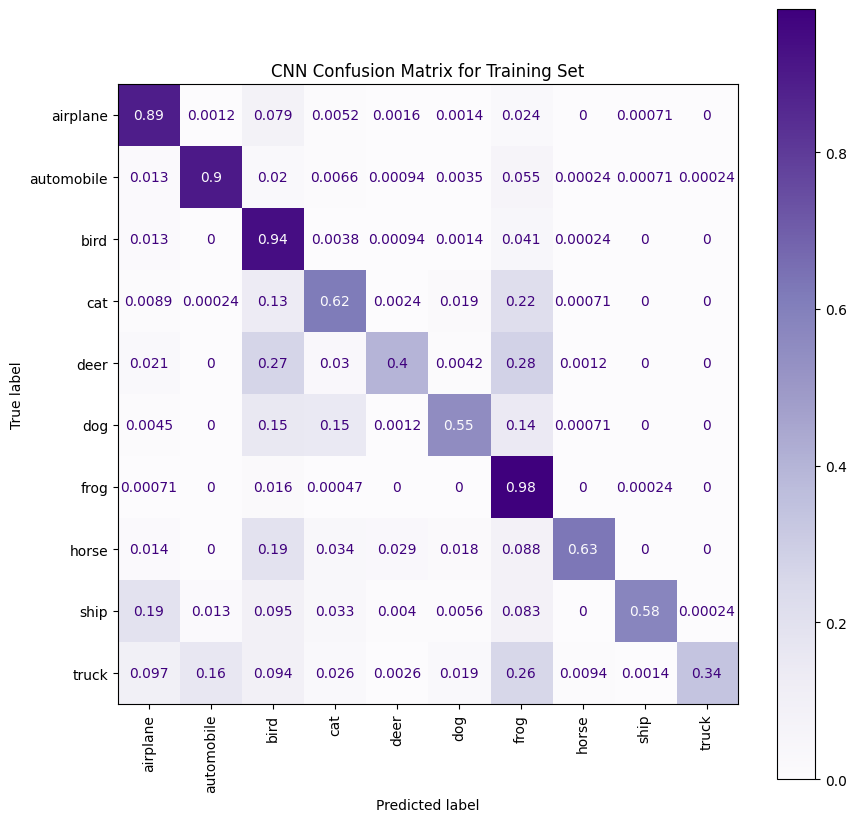

In [35]:

cnn_pred_train = np.argmax(model_cnn.predict(X_train),axis=-1)
plot_confusion_matrix(y_train, cnn_pred_train, title="CNN Confusion Matrix for Training Set")
plt.show()


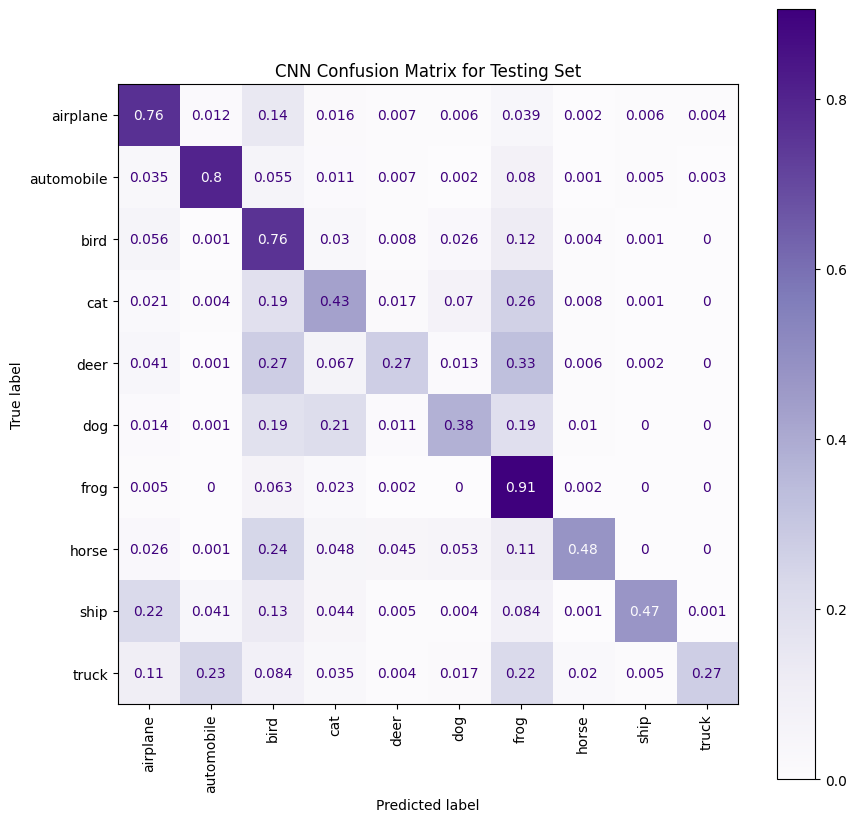

In [36]:
plot_confusion_matrix(y_test, cnn_pred_test, title="CNN Confusion Matrix for Testing Set")
plt.show()


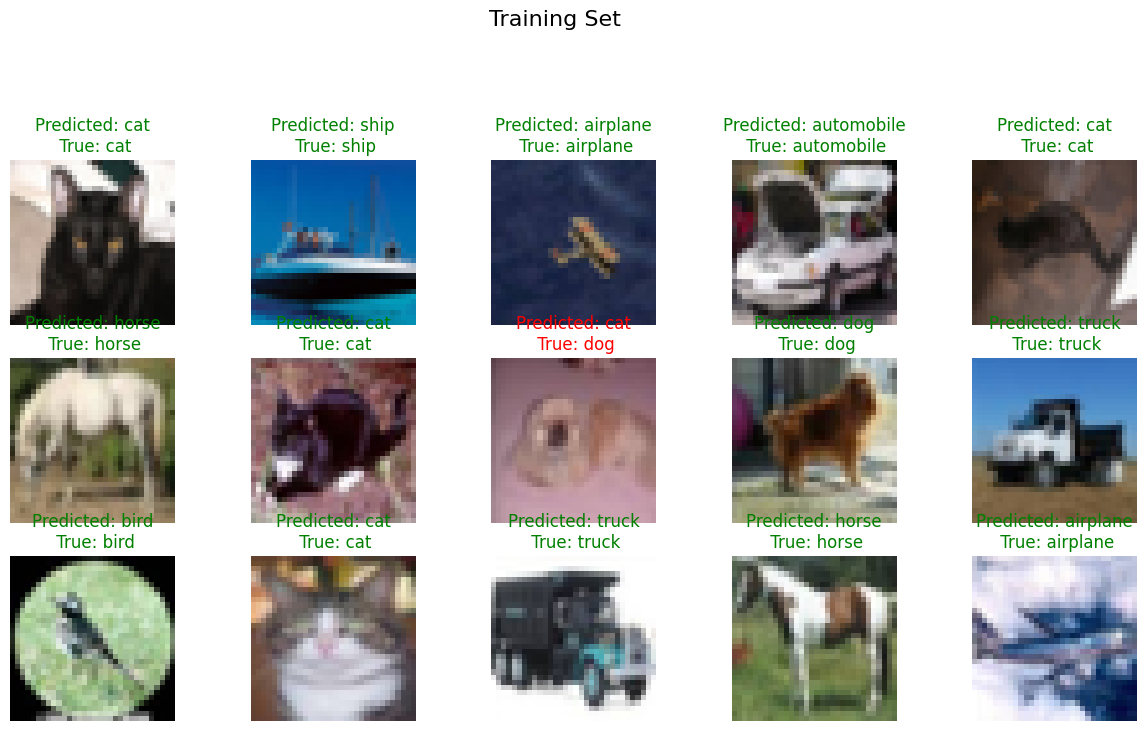

In [37]:
# CNN predict sample images
predict_sample_images(X_train, y_train, cnn_pred_train, 3, 5, class_names, 'Training Set')

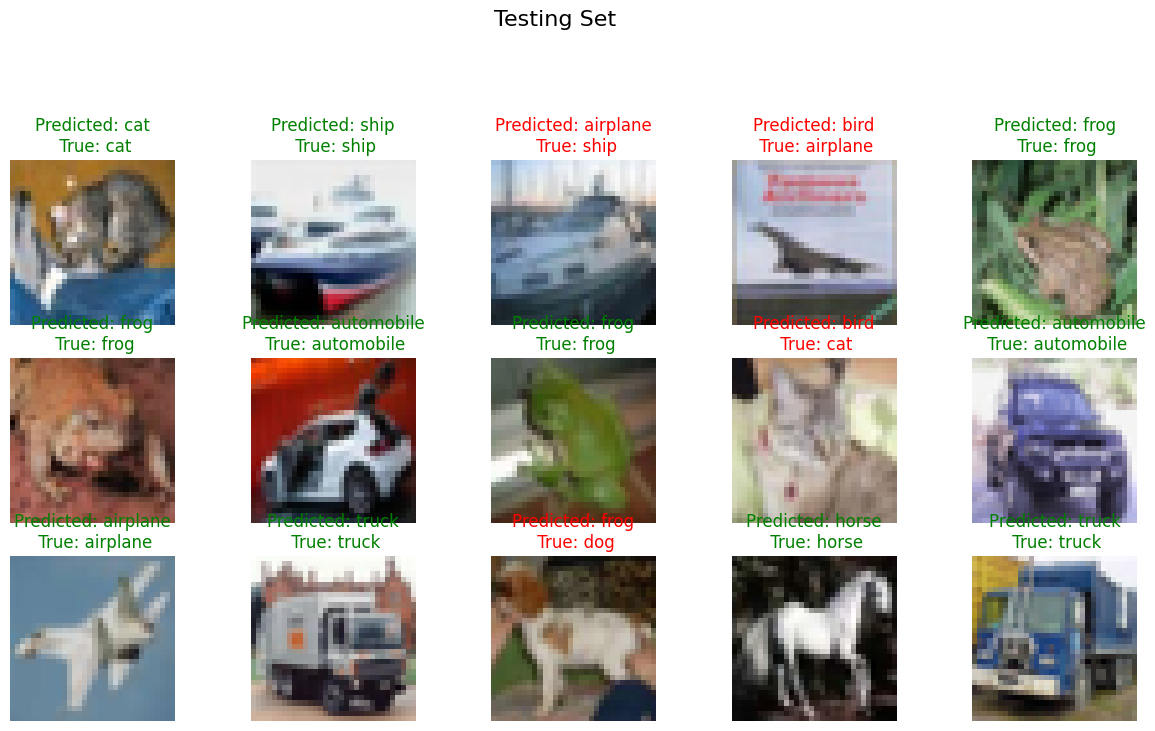

In [38]:
# CNN predict sample images
predict_sample_images(X_test, y_test, cnn_pred_test, 3, 5, class_names, 'Testing Set')

### Model comparison

In [95]:
# def predict_sample_images(images, true_labels, pred_labels, title, colors):
#     num = 8
#     plt.figure(figsize=(12, 6))
#     plt.suptitle(title, fontsize=12)
#     for i in range(num):
#       ax = plt.subplot(2, num//2, i + 1)
#       plt.imshow(images[i])
#       plt.axis('off')
#       ax.set_title(f"Predicted: {class_names[pred_labels[i]]}\nTrue: {class_names[true_labels[i]]}", color=colors[i], fontsize=10)
#     plt.show()

def display_images(images, true_labels, pred_labels_mlp, pred_labels_cnn, title, colors):
    num = 8
    plt.figure(figsize=(12, 6))
    plt.suptitle(title, fontsize=12)
    for i in range(num):
      ax = plt.subplot(2, num//2, i + 1)
      plt.imshow(images[i])
      plt.axis('off')
      ax.set_title(f"MLP predicted: {class_names[pred_labels_mlp[i]]} \nCNN predicted: {class_names[pred_labels_cnn[i]]} \nTrue: {class_names[true_labels[i]]}", color=colors[i], fontsize=10)
    plt.show()

7/7 [==============================] - 0s 5ms/step


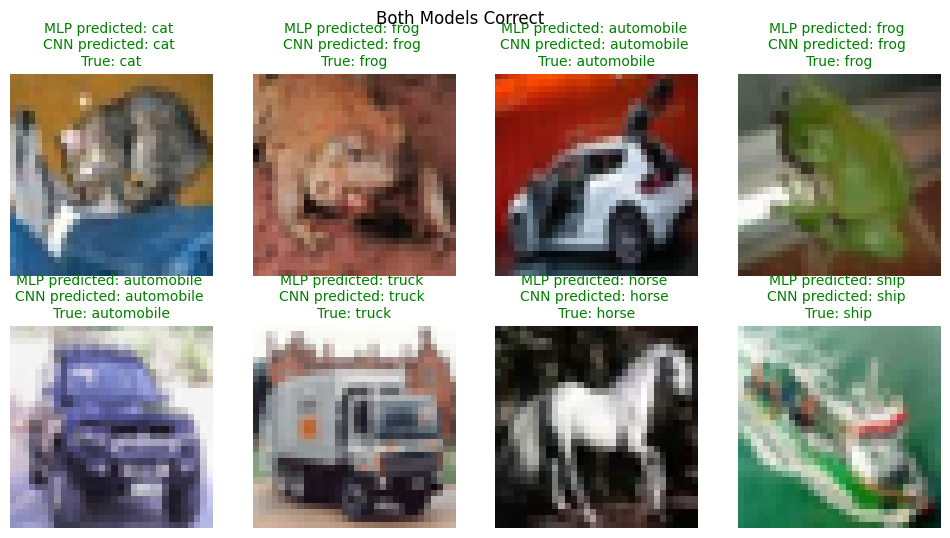

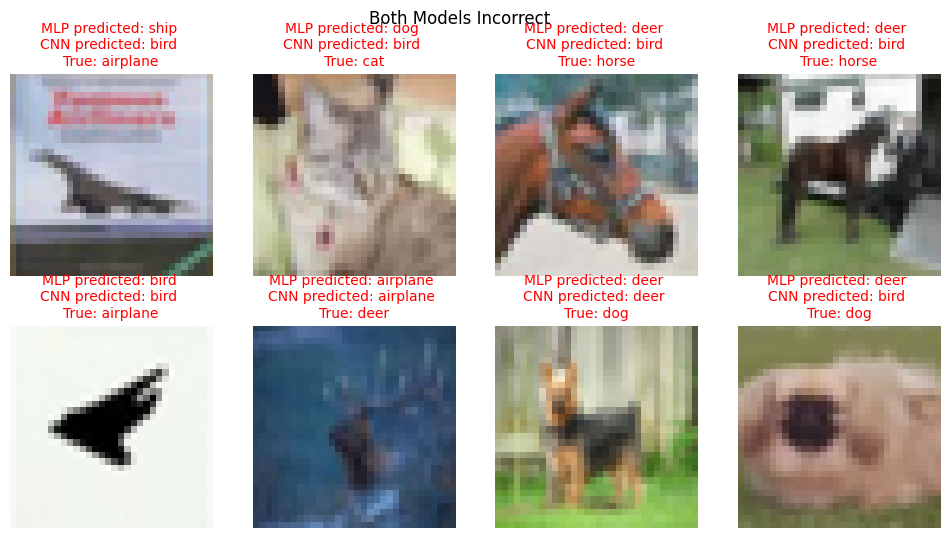

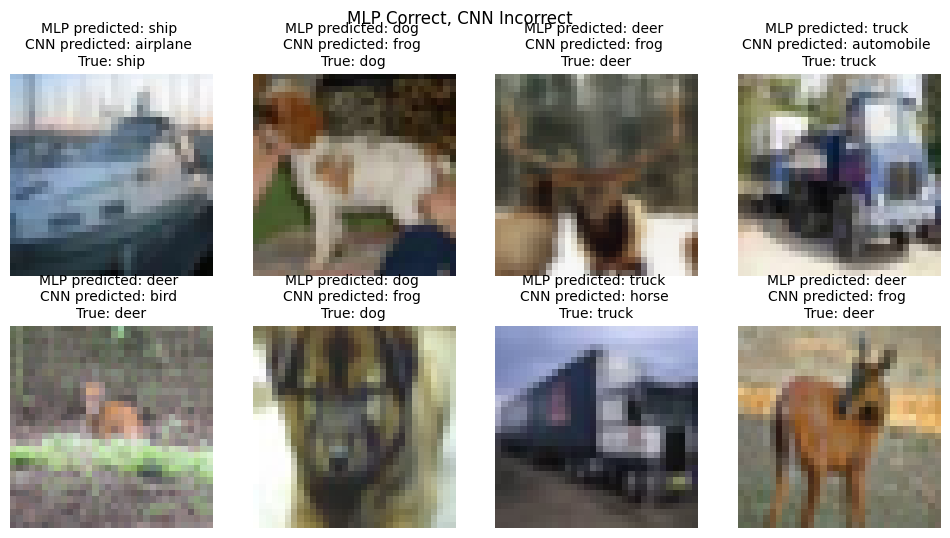

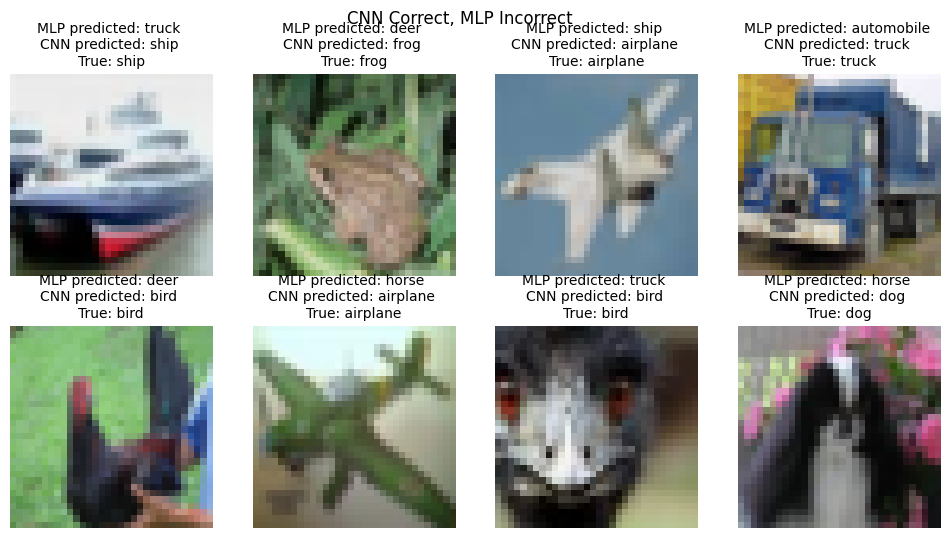

In [100]:
def compare_and_visualize_predictions(X_test, y_test, model_mlp, model_cnn, class_names, num_instances=200):
    predictions_mlp = model_mlp.predict(X_test[:num_instances])
    predictions_cnn = model_cnn.predict(X_test[:num_instances])

    # print(predictions_mlp)

    pred_labels_mlp = np.argmax(predictions_mlp, axis=1)
    pred_labels_cnn = np.argmax(predictions_cnn, axis=1)

    # print(pred_labels_mlp)

    y_test = y_test.flatten()

    indices_lists = [
        np.where((pred_labels_mlp == y_test[:num_instances]) & (pred_labels_cnn == y_test[:num_instances]))[0],
        np.where((pred_labels_mlp != y_test[:num_instances]) & (pred_labels_cnn != y_test[:num_instances]))[0],
        np.where((pred_labels_mlp == y_test[:num_instances]) & (pred_labels_cnn != y_test[:num_instances]))[0],
        np.where((pred_labels_mlp != y_test[:num_instances]) & (pred_labels_cnn == y_test[:num_instances]))[0]
    ]

    titles = ["Both Models Correct", "Both Models Incorrect", "MLP Correct, CNN Incorrect", "CNN Correct, MLP Incorrect"]
    colors = [['green'] * num_instances, ['red'] * num_instances, ['black'] * num_instances, ['black'] * num_instances]

    for i, indices in enumerate(indices_lists):
        sample_images = X_test[indices][:num_instances]
        true_labels = y_test[indices][:num_instances]
        #pred_labels = pred_labels_mlp[indices][:num_instances] if i in [0, 2] else pred_labels_cnn[indices][:num_instances]
        # display_images(sample_images, true_labels, pred_labels_mlp, pred_labels_cnn, title=titles[i], colors=colors[i])

        display_images(sample_images, true_labels, pred_labels_mlp[indices][:num_instances], pred_labels_cnn[indices][:num_instances], title=titles[i], colors=colors[i])


# Usage example:
compare_and_visualize_predictions(X_test, y_test, model_mlp, model_cnn, class_names)

